# Температура звезд

## Описание задачи

Целью проекта является разработка модели машинного обучения, предсказывающей абсолютную температуру на поверхности звезды.<BR>
Для разработки модели предоставляется информация о 240 изученных звездах. По каждой из которых имеется следующая информация:<BR>
- Относительная светимость (L/Lo), относительно солнца<BR>
- Относительный радиус (R/Ro), относительно солнца<BR>
- Асболютная звездная величина<BR>
- Цвет звезды (значения: white, red, blue, yellow, yellow-orange)<BR>
- Тип звезды (значения: коричневый карлик 0, красный карлик 1, белый карлик 2, зв. главной последовательности 3, сверхгигант 4, гипергигант 5)    <BR>
- Абсолютная температура. В кельвинах<BR>

## Загрузка данных

In [3]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import platform
import matplotlib 
import seaborn as sns

import torch.nn.functional as F

from math import ceil
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

RANDOM_STATE = 34567
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [4]:
host = platform.node()
filename = "autos.csv"

# На машинах исполнителя проекта файл с данными доступен через символический путь, 
# ссылающийса на папку на яндекс.диске, где расположен загружаемый файл. 
# В случае если хостом где выполняется анализ является какая-либо другая машина, 
# используем путь по умолчанию.
try:    
    if host in ['22varivoda','Gover-pc','MSI','gmain']:
        filepath    = r'C:/_YDsymlink/dataSciencePlus/datasets/'
    else:
        filepath    = '/datasets/'
except:
    print("Не удалось подгрузить данные")
    
pd.reset_option('^display.',silent=True)
pd.set_option('display.float_format', str)

In [5]:
data = pd.read_csv(filepath+r'6_class.csv', sep=',')

In [6]:
def print_html(message):
    from IPython.display import display, HTML
    out_msg = HTML(message)
    display(out_msg)

## Исследовательский анализ

#### Первичный осмотр данных

In [7]:
data.head(4)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.0024,0.17,16.12,0,Red
1,1,3042,0.0005,0.1542,16.6,0,Red
2,2,2600,0.0003,0.102,18.7,0,Red
3,3,2800,0.0002,0.16,16.65,0,Red


Выполним следующие изменения: <BR>
- Изменим названия столбцов на более удобные.<BR>
- Удалим первый столбец (Unnamed: 0). Так как он дублирует индекс

In [8]:
old_names = data.columns
new_names = ['ind','temperature','rel_luminosity','rel_radius','abs_magnitude','type','color']
data.columns = new_names
#data = data.drop(columns='ind')

In [9]:
numerical   = ['rel_luminosity','rel_radius','abs_magnitude'] # + 'temperature', но температуру в список не включаем
categorical = ['type','color']

In [10]:
data.head(4)

,ind,temperature,rel_luminosity,rel_radius,abs_magnitude,type,color
0,0,3068,0.0024,0.17,16.12,0,Red
1,1,3042,0.0005,0.1542,16.6,0,Red
2,2,2600,0.0003,0.102,18.7,0,Red
3,3,2800,0.0002,0.16,16.65,0,Red


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ind             240 non-null    int64  
 1   temperature     240 non-null    int64  
 2   rel_luminosity  240 non-null    float64
 3   rel_radius      240 non-null    float64
 4   abs_magnitude   240 non-null    float64
 5   type            240 non-null    int64  
 6   color           240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


#### Проверка пропусков, нулевых значений, диапазона значений, оценка графиков

##### Относительная светимость (rel_luminosity)

In [12]:
print(data['rel_luminosity'].value_counts( ) )
print(f"NULL-записей в столбце: {data['rel_luminosity'].isna().sum()}")
print(f"Записей где rel_luminosity = 0 : {len(data.loc[data['rel_luminosity'] == 0])}")

200000.0    5
0.00067     3
0.00014     3
0.00098     3
0.0005      2
           ..
0.59        1
0.153       1
0.085       1
0.357       1
294903.0    1
Name: rel_luminosity, Length: 208, dtype: int64
NULL-записей в столбце: 0
Записей где rel_luminosity = 0 : 0


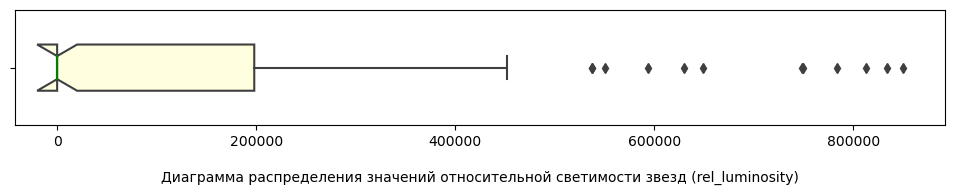

In [13]:
f, axes = plt.subplots(1, 1, figsize=(12, 1.5), sharex=True, sharey=True)

sns.boxplot(data=data, 
            x='rel_luminosity', 
            width=0.4,             
            notch=True, 
            medianprops={'color':'green'},
            boxprops={"facecolor": ( 'lightyellow')},
            ax = axes            
           )
axes.set_xlabel('\nДиаграмма распределения значений относительной светимости звезд (rel_luminosity)')
plt.show()

In [14]:
len(data.loc[data['rel_luminosity'] > 400000])

15

Диаграмма рассеяния показывает что плотность основная масса значений смещена ближе к нулевому значению,<BR>
3/4 значений в пределах значения 200000. За пределы "усов" диаграммы справа выходят лишь примерно 15 значений.<BR>
Но вряд ли можно их отбросить так как учитывая очень маленькую выборку они могут играть серьёзную роль в прогнозах.

##### Относительный радиус (rel_radius)

In [15]:
print(data['rel_radius'].value_counts( ) )
print(f"NULL-записей в столбце: {data['rel_radius'].isna().sum()}")
print(f"Записей где rel_radius = 0 : {len(data.loc[data['rel_radius'] == 0])}")

36.0      3
0.11      3
1324.0    3
0.24      3
83.0      2
         ..
0.0089    1
0.0109    1
0.0087    1
0.0131    1
1783.0    1
Name: rel_radius, Length: 216, dtype: int64
NULL-записей в столбце: 0
Записей где rel_radius = 0 : 0


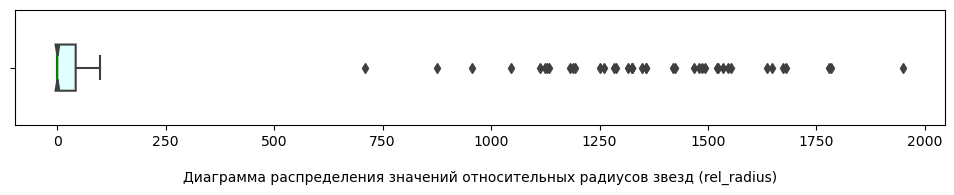

In [16]:
f, axes = plt.subplots(1, 1, figsize=(12, 1.5), sharex=True, sharey=True)

sns.boxplot(data=data, 
            x='rel_radius', 
            width=0.4,             
            notch=True, 
            medianprops={'color':'green'},
            boxprops={"facecolor": ( 'lightcyan')},
            ax = axes            
           )
axes.set_xlabel('\nДиаграмма распределения значений относительных радиусов звезд (rel_radius)')
plt.show()

In [17]:
len(data.loc[data['rel_radius'] > 250])

40

In [18]:
data.loc[data['rel_radius'] > 250, 'type'].value_counts()

5    40
Name: type, dtype: int64

В случае с радиусом картина ещё более яркая, большинство звезд в той или иной степени сопоставимы по размерам с солнцем, если про космические объекты вообще можно утверждать что-то подобное. Но небольша часть примерно в 40 звезд сильно отличается размером. И всё это гипергиганты, что вполне логично.

##### Абсолютная звездная величина (abs_magnitude)

In [19]:
print(data['abs_magnitude'].value_counts( ) )
print(f"NULL-записей в столбце: {data['abs_magnitude'].isna().sum()}")
print(f"Записей где abs_magnitude = 0 : {len(data.loc[data['abs_magnitude'] == 0])}")

12.23    3
11.34    2
-10.7    2
-7.22    2
14.23    2
        ..
13.78    1
12.45    1
12.17    1
12.13    1
-7.8     1
Name: abs_magnitude, Length: 228, dtype: int64
NULL-записей в столбце: 0
Записей где abs_magnitude = 0 : 0


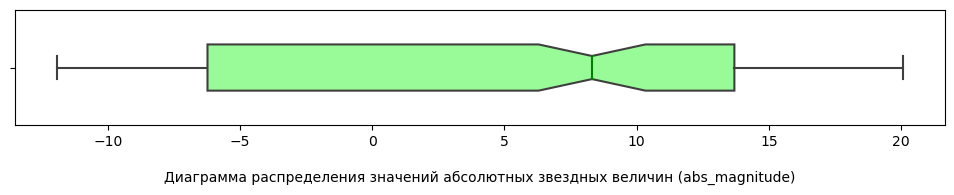

In [20]:
f, axes = plt.subplots(1, 1, figsize=(12, 1.5), sharex=True, sharey=True)

sns.boxplot(data=data, 
            x='abs_magnitude', 
            width=0.4,             
            notch=True, 
            medianprops={'color':'green'},
            boxprops={"facecolor": ( 'PaleGreen')},
            ax = axes            
           )
axes.set_xlabel('\nДиаграмма распределения значений абсолютных звездных величин (abs_magnitude)')
plt.show()

Разброс не столь большой как в случае с предыдущими признаками

##### Звездный цвет (color)

In [21]:
print(data['color'].value_counts( ) )
print(f"NULL-записей в столбце: {data['color'].isna().sum()}")
print(f"Записей где color = '' : {len(data.loc[data['color'] == ''])}")

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: color, dtype: int64
NULL-записей в столбце: 0
Записей где color = '' : 0


Часть значений имеют общий смысл но отмечаются как разные. Попробуем стандартизировать их.<BR>
Произведем следующие действия:<BR>
- Все заглавные буквы уменьшим<BR>
- Уберем пробелы в начале и конце названий<BR>
- Заменим все пробелы на дефисы
- Заменим white-yellow на yellow-white чтобы значения совпало с аналогичными

In [22]:
data['color']=data['color'].str.lower()
data['color']=data['color'].str.replace('^\s+','',regex=True)
data['color']=data['color'].str.replace('\s+$','',regex=True)
data.loc[data['color'].str.contains(' '),'color'] = data.loc[data['color'].str.contains(' '),'color'].str.replace('\s+','-',regex=True)
data.loc[data['color']=='white-yellow','color']='yellow-white'

Перепроверим спектр значений

In [23]:
print(data['color'].value_counts( ) )
print(f"NULL-записей в столбце: {data['color'].isna().sum()}")

red                   112
blue                   56
blue-white             41
white                  10
yellow-white            9
yellowish-white         3
yellowish               3
whitish                 2
orange                  2
pale-yellow-orange      1
orange-red              1
Name: color, dtype: int64
NULL-записей в столбце: 0


Так гораздо лучше. Посмотрим на столбчатую диаграмму распределения цветов

In [24]:
temp_vals = pd.DataFrame(data= data['color'].value_counts(), index=data['color'].value_counts().index)
temp_vals.columns=['stars_count']
temp_vals['color']=temp_vals.index

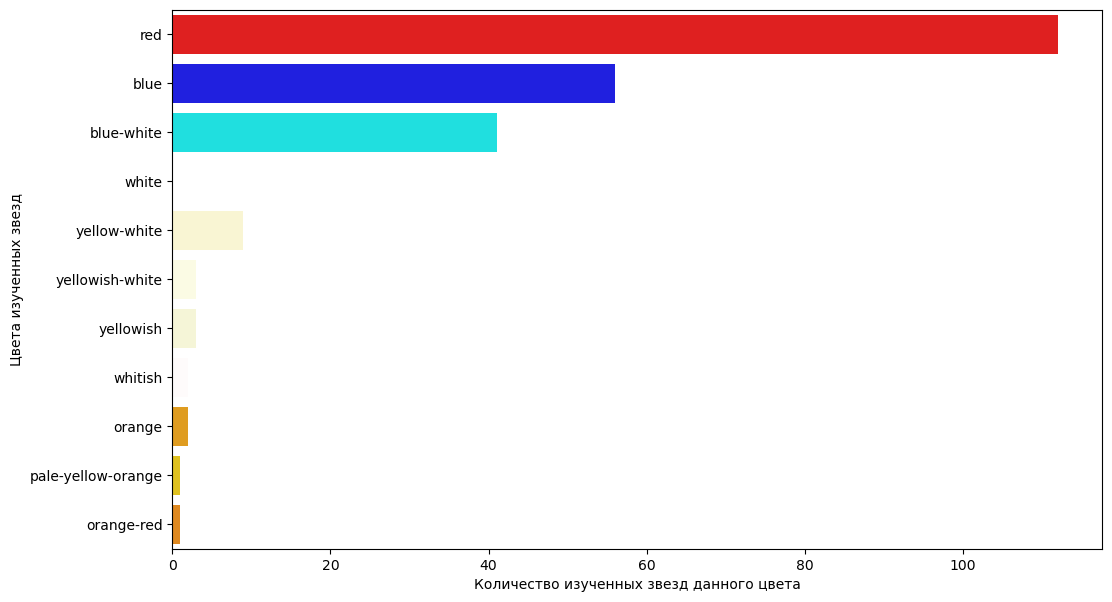

In [25]:
cols = ['red','blue','cyan','white','LemonChiffon','LightYellow','LightGoldenrodYellow','Snow','Orange','Gold','DarkOrange'];

f, axes = plt.subplots(1, 1, figsize=(12, 7), sharex=True, sharey=True)

sns.barplot(data=temp_vals,y='color',x='stars_count', palette=cols);
axes.set_xlabel('Количество изученных звезд данного цвета');
axes.set_ylabel('Цвета изученных звезд');
plt.show()

Преимущественно имеем дело с красными звездами

##### Тип звезды (type)

In [26]:
print(data['type'].value_counts( ) )
print(f"NULL-записей в столбце: {data['type'].isna().sum()}")

0    40
1    40
2    40
3    40
4    40
5    40
Name: type, dtype: int64
NULL-записей в столбце: 0


Взято по 40 звезд каждого класса, так что нет смысла ничего визуализировать.

##### Температура (temperature)

In [27]:
print(data['temperature'].value_counts( ) )
print(f"NULL-записей в столбце: {data['temperature'].isna().sum()}")
print(f"Записей где temperature = 0 : {len(data.loc[data['temperature'] == 0])}")

3600     3
3218     2
2650     2
3625     2
3324     2
        ..
10980    1
13720    1
19860    1
5300     1
37882    1
Name: temperature, Length: 228, dtype: int64
NULL-записей в столбце: 0
Записей где temperature = 0 : 0


In [28]:
print(f"Звезд с температурой меньше 1000 градусов: { len( data.loc[data['temperature'] < 1000 ] ) }")

Звезд с температурой меньше 1000 градусов: 0


In [29]:
print(f"Звезд с температурой больше 100 тыс. градусов: { len( data.loc[data['temperature'] >= 100000 ] ) }")

Звезд с температурой больше 100 тыс. градусов: 0


Похоже что аномалий по температуре нет

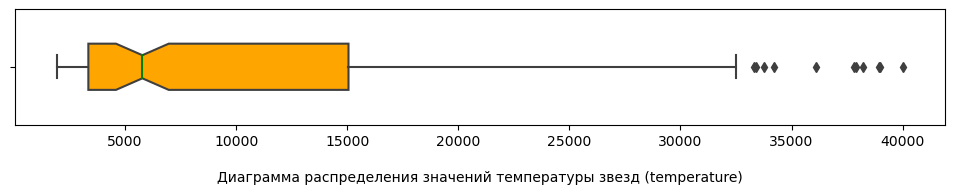

In [30]:
f, axes = plt.subplots(1, 1, figsize=(12, 1.5), sharex=True, sharey=True)

sns.boxplot(data=data, 
            x='temperature', 
            width=0.4,             
            notch=True, 
            medianprops={'color':'green'},
            boxprops={"facecolor": ( 'orange')},
            ax = axes            
           )
axes.set_xlabel('\nДиаграмма распределения значений температуры звезд (temperature)')
plt.show()

In [31]:
len(data.loc[data['temperature'] >= 15000])

60

С температурой примерно та же картина как и с относительной светимостью

Так как температура - наш целевой признак, посмотрим, есть ли какая-то видимая прямая связь между температурой, превышающей 15000 К и другими признаками.

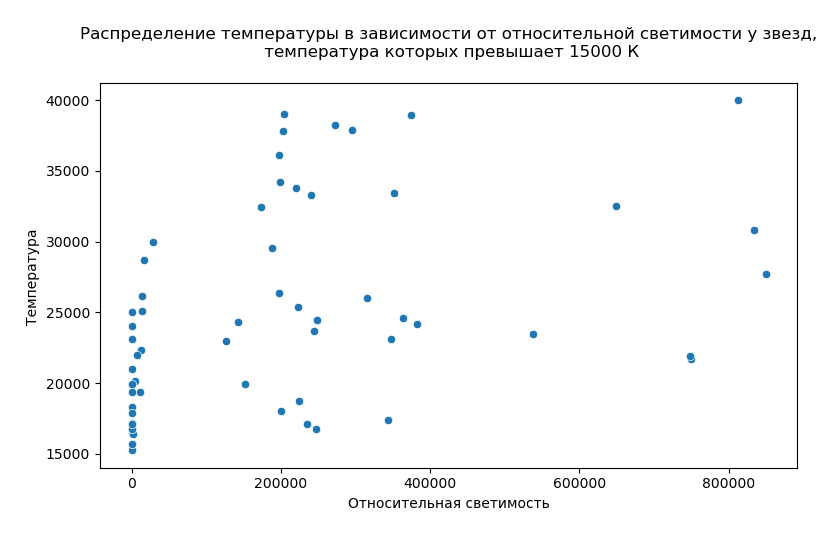

In [32]:
x_parameter = 'rel_luminosity'
f, axes = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
sns.scatterplot(data.loc[data['temperature'] > 15000], y='temperature',x=x_parameter, ax=axes)
axes.set_title("\nРаспределение температуры в зависимости от относительной светимости у звезд,\n температура которых превышает 15000 К\n")
axes.set_xlabel('Относительная светимость\n')
axes.set_ylabel('\nТемпература ')
plt.show()

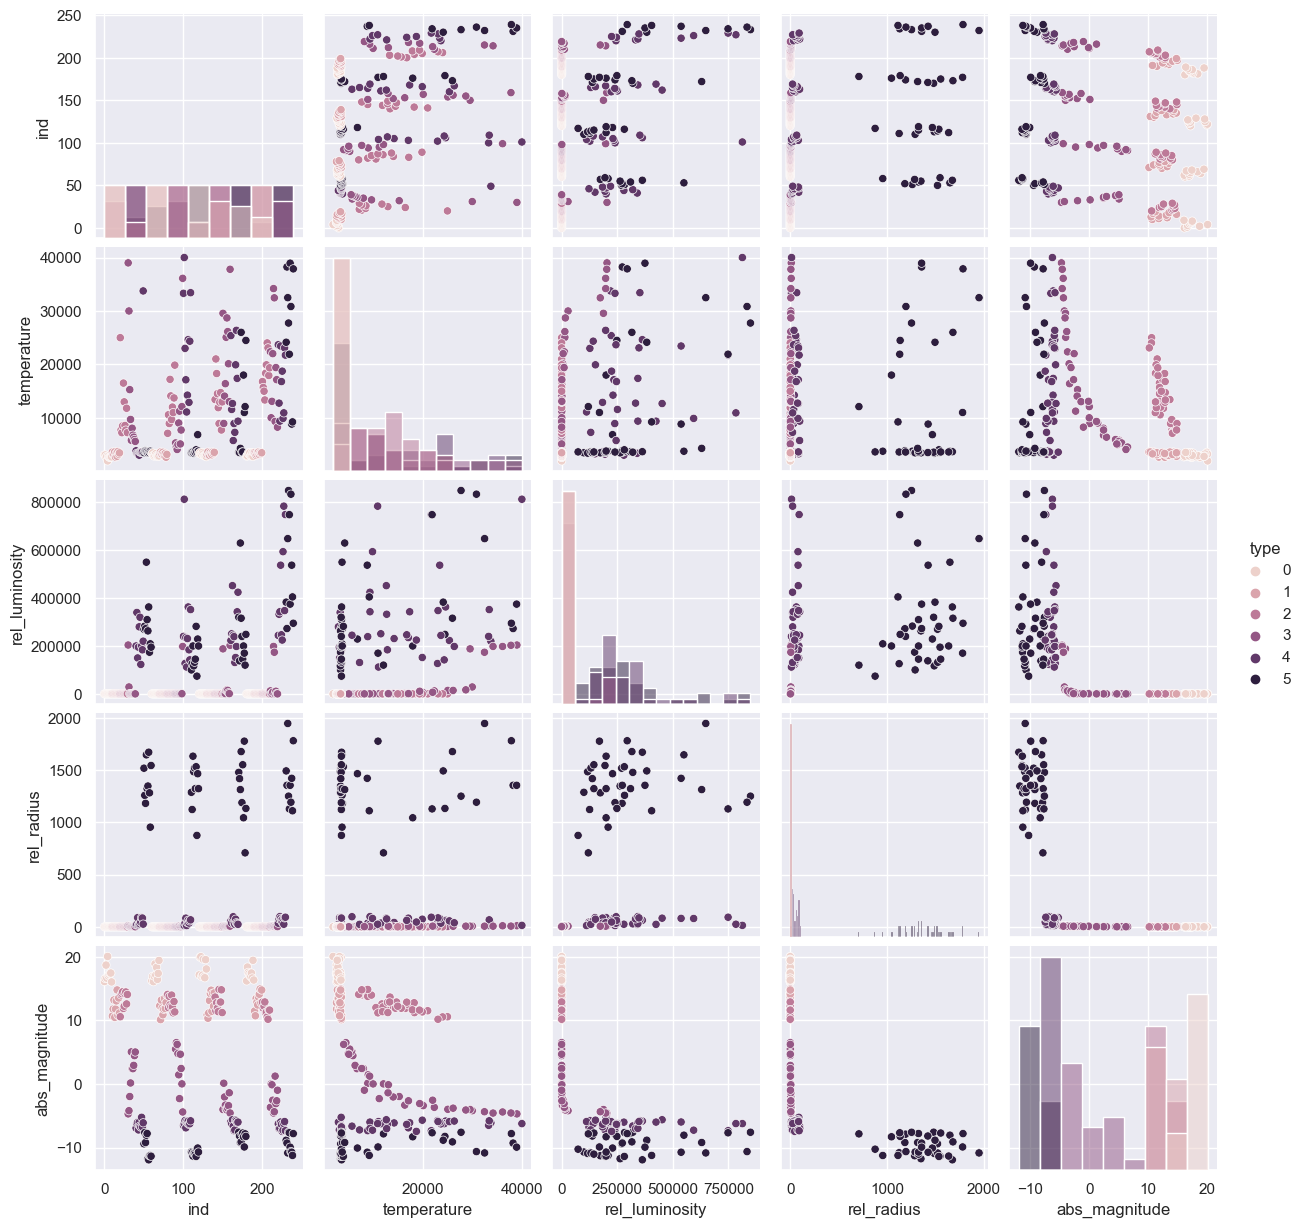

In [60]:
sns.pairplot(data, hue='type', diag_kind='hist');    

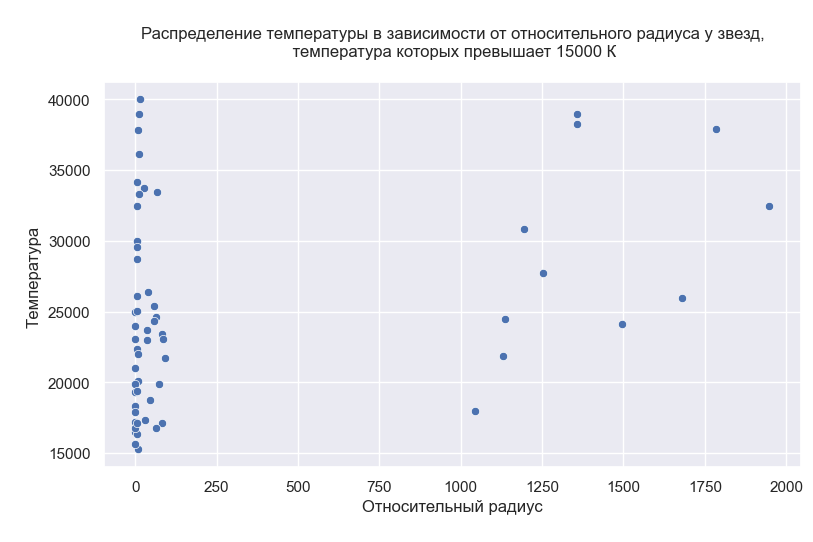

In [63]:
x_parameter = 'rel_radius'
f, axes = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
sns.scatterplot(data.loc[data['temperature'] > 15000], y='temperature',x=x_parameter, ax=axes)
axes.set_title("\nРаспределение температуры в зависимости от относительного радиуса у звезд,\n температура которых превышает 15000 К\n")
axes.set_xlabel('Относительный радиус\n')
axes.set_ylabel('\nТемпература ')
plt.show()

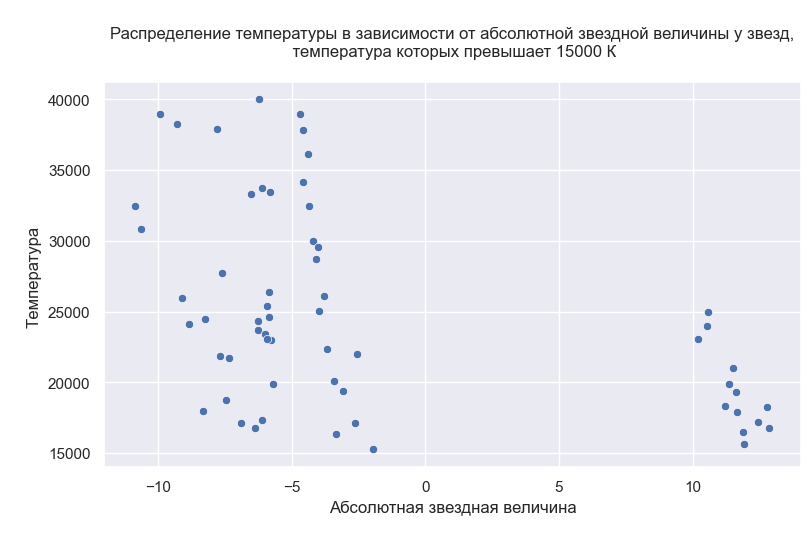

In [64]:
x_parameter = 'abs_magnitude'
f, axes = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
sns.scatterplot(data.loc[data['temperature'] > 15000], y='temperature',x=x_parameter, ax=axes)
axes.set_title("\nРаспределение температуры в зависимости от абсолютной звездной величины у звезд,\n температура которых превышает 15000 К\n")
axes.set_xlabel('Абсолютная звездная величина\n')
axes.set_ylabel('\nТемпература ')
plt.show()

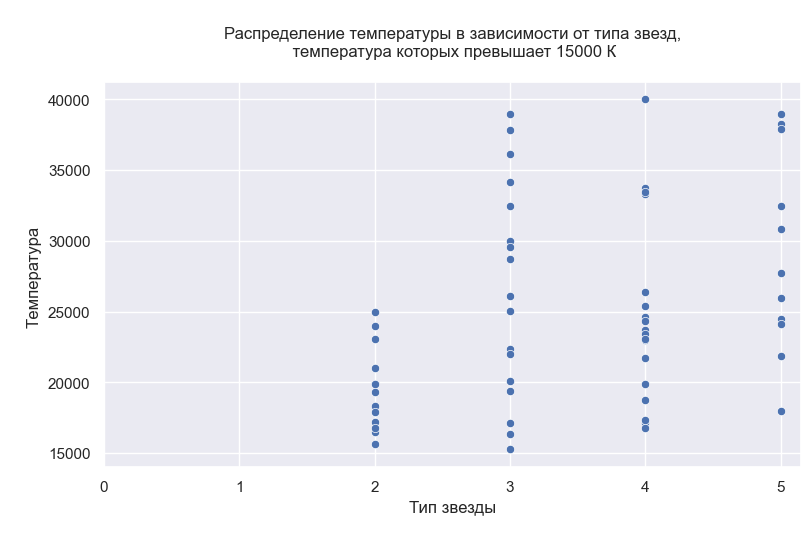

In [65]:
x_parameter = 'type'
f, axes = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
sns.scatterplot(data.loc[data['temperature'] > 15000], y='temperature',x=x_parameter, ax=axes,)
axes.set_title("\nРаспределение температуры в зависимости от типа звезд,\n температура которых превышает 15000 К\n")
axes.set_xlabel('Тип звезды\n')
axes.set_ylabel('\nТемпература ')
axes.set_xticks([0,1,2,3,4,5])
plt.show()

<AxesSubplot:xlabel='type', ylabel='temperature'>

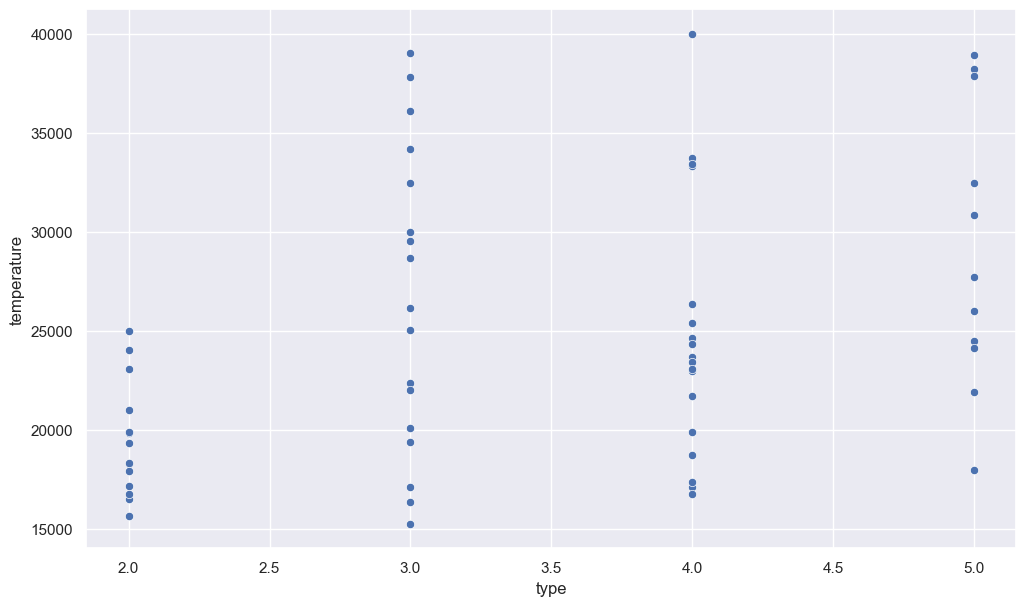

In [66]:
sns.scatterplot(data.loc[data['temperature'] > 15000], y='temperature',x='type')

Наблюдается некоторая связь повышенной температуры звезд от относительного радиуса. Чем меньше звезда, тем с большей вероятностью её температура будет высокой. Также есть некоторая связь с относительной светимостью и абсолютной звездной величеной, но эти связи менее выражены.

#### Вывод

Данные предоставлены по 250 звездам, разделенным по классам звезд. Всего шесть классов, из каждого класса предоставлена информация по сорока звездам. Пропуски в данных не обнаружены. Большинство показателей по звездам-гипергигантам существенно отличаются от показателей остальных звезд в большую сторону. В то же повышенные значения целевого признака (температуры) в некоторой степени имеют связь с размером звезд. При этом наоборот, она больше для небольших звезд, а не для для звезд гигантов. 

### Подготовка данных к построению модели

In [67]:
df_train, df_test = train_test_split(data, test_size = 0.1, random_state=RANDOM_STATE)

Имеем следующую проблему: данных мало, из них данных похожих на выбросы много. Но выбрасывать данные из таблицы мы не можем. По некоторым звездам есть дисбаланс (у 15 запией относительная светимость сильно выше остальных, 40 записей то же касается относительного радиуса. Попробуем немного сбалансировать данные, добавив немного измененные копии звезд с редкими показателями (сделав аугментацию).

In [68]:
df_lum = df_train.loc[df_train['rel_luminosity'] > 400000].copy() 
df_rad = df_train.loc[df_train['rel_radius']     > 250].copy()    

# Аугментация звезд с большой относительной светимостью
for step in range(4):
    for d in range(len(df_lum)):
        t_d = df_lum.iloc[d]
        new_star = {'temperature': t_d['temperature'] * (0.99+random.uniform(0, 0.01)),
                    'rel_luminosity':t_d['rel_luminosity']* (0.99+random.uniform(0, 0.01)),
                    'rel_radius':t_d['rel_radius']* (0.99+random.uniform(0, 0.01)),
                    'abs_magnitude':t_d['abs_magnitude']* (0.99+random.uniform(0, 0.01)),
                    'ind':t_d['ind'],
                    'type':t_d['type'],
                    'color':t_d['color']
                   }
        new_df = pd.DataFrame([new_star])
        df_train = pd.concat([df_train, new_df], axis=0, ignore_index=True)
        
# Аугментация звезд с большими радиусами
for step in range(3):
    for d in range(len(df_rad)):
        t_d = df_rad.iloc[d]
        new_star = {'temperature': t_d['temperature'] * (0.99+random.uniform(0, 0.01)),
                    'rel_luminosity':t_d['rel_luminosity']* (0.99+random.uniform(0, 0.01)),
                    'rel_radius':t_d['rel_radius']* (0.99+random.uniform(0, 0.01)),
                    'abs_magnitude':t_d['abs_magnitude']* (0.99+random.uniform(0, 0.01)),
                    'ind':t_d['ind'],
                    'type':t_d['type'],
                    'color':t_d['color']
                   }
        new_df = pd.DataFrame([new_star])
        df_train = pd.concat([df_train, new_df], axis=0, ignore_index=True)        

In [69]:
df_train = df_train.sample(frac=1,random_state=RANDOM_STATE )

In [70]:
df_X = df_train.drop(columns=['temperature','ind'])
df_y = df_train['temperature']



In [71]:
X_train_source, X_valid_source, y_train_source, y_valid_source = train_test_split(
                                                                     df_X, 
                                                                     df_y, 
                                                                     test_size=0.2, 
                                                                     random_state=RANDOM_STATE
                                                                 )


In [72]:
X_test = df_test.drop(columns=['temperature','ind'])
y_test = df_test['temperature']

Обработка категориальных признаков. Добавим кодирование (OHE)

In [73]:
encoder = OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore' )
encoder.fit(X_train_source[categorical]);

In [74]:
ohe_train = encoder.transform(X_train_source[categorical])
ohe_valid = encoder.transform(X_valid_source[categorical])
ohe_test  = encoder.transform(X_test[categorical])

Обработка числовых признаков. Добавим масштабирование

In [75]:
scaler = StandardScaler()
scaler.fit(X_train_source[numerical]);

In [76]:
scaled_train = scaler.transform(X_train_source[numerical])
scaled_valid = scaler.transform(X_valid_source[numerical])
scaled_test  = scaler.transform(X_test[numerical])

In [77]:
X_train_processed = np.concatenate([ohe_train, scaled_train],axis=1)
X_valid_processed = np.concatenate([ohe_valid, scaled_valid],axis=1)
X_test_processed  = np.concatenate([ohe_test,  scaled_test], axis=1)

## Построение базовой нейронной сети

In [78]:
neurons_in   = X_train_processed.shape[1]

In [79]:
X_train = torch.FloatTensor(X_train_processed)
X_valid = torch.FloatTensor(X_valid_processed)
X_test  = torch.FloatTensor(X_test_processed)
y_train = torch.FloatTensor(y_train_source.to_numpy(dtype=np.float64))
y_valid = torch.FloatTensor(y_valid_source.to_numpy(dtype=np.float64))
y_test  = torch.FloatTensor(y_test.to_numpy(dtype=np.float64))

In [80]:
best_results = list()

#### Базовая сеть: архитектура 1. Четыре скрытых слоя

In [81]:
class NET_4H(nn.Module):
    def __init__(self, neurons_in, 
                       neurons_hl_1, 
                       neurons_hl_2, 
                       neurons_hl_3, 
                       neurons_hl_4, 
                       neurons_out    ):
        super(NET_4H,self).__init__()
        self.fc1 = nn.Linear(neurons_in,neurons_hl_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(neurons_hl_1,neurons_hl_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(neurons_hl_2,neurons_hl_3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(neurons_hl_3,neurons_hl_4)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(neurons_hl_4,neurons_out)
        self.act5 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        return x

In [82]:
neurons_hl_1 = round(X_train_processed.shape[1]* 0.8)
neurons_hl_2 = round(neurons_hl_1* 0.8)
neurons_hl_3 = round(neurons_hl_2* 0.8)
neurons_hl_4 = round(neurons_hl_3* 0.8)
neurons_out  = 1

In [83]:
net_4h = NET_4H(neurons_in, 
                neurons_hl_1, 
                neurons_hl_2, 
                neurons_hl_3, 
                neurons_hl_4, 
                neurons_out)

In [84]:
num_epochs = 30000
test_every = round(num_epochs/20)
loss       = nn.MSELoss()
optimizer  = torch.optim.Adam(net_4h.parameters(), lr=1e-3)

mse_test = nn.MSELoss()

In [85]:
%%time
best_rmse = 1000000
best_batch_size = 0
best_epoch = 0
best_net = 0
metrics = []

print(f"Архитектура 1 (4 скрытых слоя). Запуск обучения в {num_epochs} эпох. Тестирование раз в {test_every} эпох")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net_4h.forward(X_train).flatten()
    
    loss_value = loss(preds, y_train)

    loss_value.backward()
    
    optimizer.step()
    
    if epoch % test_every == 0 or epoch == num_epochs - 1:
        net_4h.eval()
        test_preds = net_4h.forward(X_valid)
        trmse = mean_squared_error(y_valid.detach().numpy() , test_preds.detach().numpy()) ** 0.5
        print(f"Эпоха {epoch} rmse =",trmse)
        metrics.append(trmse)
        if trmse < best_rmse:
            best_rmse = trmse
            best_epoch = epoch
            best_net = net_4h
        if trmse > best_rmse *1.2:
            break
            
best_results.append({'hidden layers':4,
                     'layers':[neurons_in,neurons_hl_1, neurons_hl_2, neurons_hl_3, neurons_hl_4, neurons_out],
                     'epoch':best_epoch,
                     'rmse':best_rmse,
                     'median_metric': np.median(metrics),
                     'mean_metric':np.mean(metrics),
                     'best_net':best_net
                    })

print("Обучение завершено")

Архитектура 1 (4 скрытых слоя). Запуск обучения в 30000 эпох. Тестирование раз в 1500 эпох
Эпоха 0 rmse = 16653.890356310145
Эпоха 1500 rmse = 7518.133544969789
Эпоха 3000 rmse = 4684.731582492213
Эпоха 4500 rmse = 4591.5117336232515
Эпоха 6000 rmse = 4140.692937178511
Эпоха 7500 rmse = 4070.3630059246557
Эпоха 9000 rmse = 4016.87677182161
Эпоха 10500 rmse = 4004.1092642434223
Эпоха 12000 rmse = 4005.8326225642527
Эпоха 13500 rmse = 4015.923057031845
Эпоха 15000 rmse = 4020.3751068774664
Эпоха 16500 rmse = 3913.929227770988
Эпоха 18000 rmse = 3814.81480546566
Эпоха 19500 rmse = 3690.0978306814577
Эпоха 21000 rmse = 3777.600428843686
Эпоха 22500 rmse = 3685.787839797619
Эпоха 24000 rmse = 3511.4069829628124
Эпоха 25500 rmse = 3357.7599675974457
Эпоха 27000 rmse = 3211.0861090914395
Эпоха 28500 rmse = 3043.188952398454
Эпоха 29999 rmse = 2795.989091538091
Обучение завершено
CPU times: total: 17.8 s
Wall time: 17.9 s


Построим график 

In [56]:
star_numbers          = list(df_train.iloc[list(X_valid_source.index)]['ind'])
predicted_temperature = test_preds.detach().numpy().reshape(-1)
real_temperature      = y_valid.detach().numpy()

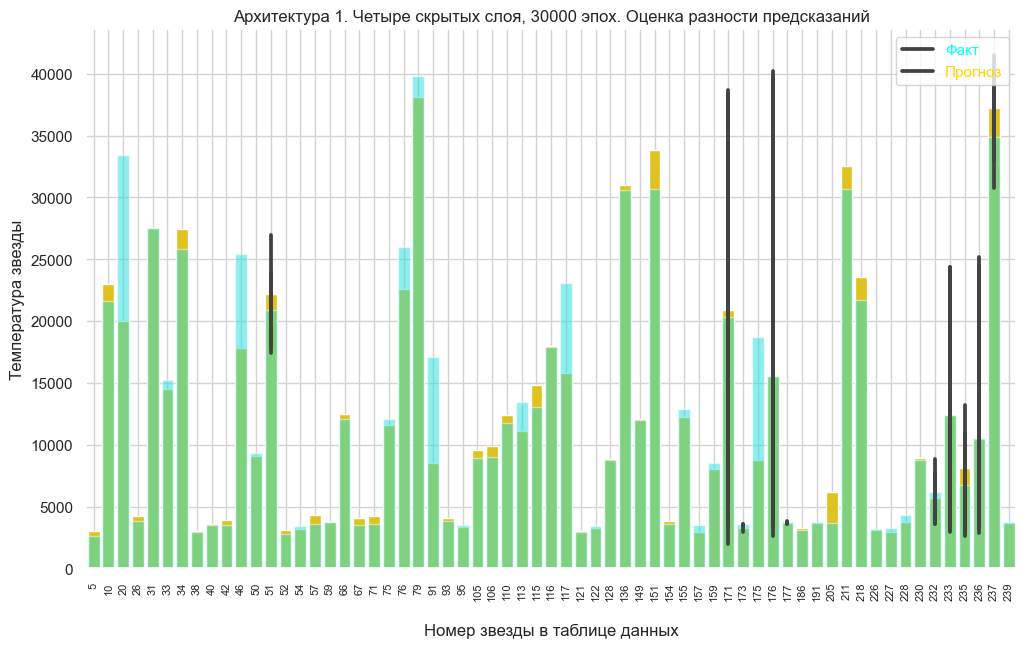

In [87]:
plt.subplots()
ax1 = sns.barplot(x=star_numbers, y=predicted_temperature, color='gold')
ax2 = sns.barplot(x=star_numbers, y=real_temperature,      color='cyan',alpha=0.5)
for bar in ax1.patches:
    bar.set_width(0.2)
for bar in ax2.patches:
    bar.set_width(0.8)    
sns.set(rc={'figure.figsize':(12,7)})
ax1.set_xlabel('\nНомер звезды в таблице данных')
ax1.set_ylabel('Температура звезды')
ax1.set_facecolor('white')
plt.grid(visible=True,color='lightgray' )
plt.legend(loc='upper right', labels=['Факт','Прогноз'],labelcolor=['cyan','gold'],facecolor='white')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.title(f'Архитектура 1. Четыре скрытых слоя, {num_epochs} эпох. Оценка разности предсказаний')
plt.show()

#### Базовая сеть: архитектура 2. Шесть скрытых слоев

Сделаем базовую модель с шестью скрытыми слоями, функции активации на всех скрытых слоях - ReLU, на выходном - Linear

In [88]:
class NET_6H(nn.Module):
    def __init__(self, neurons_in, 
                       neurons_hl_1, 
                       neurons_hl_2, 
                       neurons_hl_3, 
                       neurons_hl_4, 
                       neurons_hl_5,
                       neurons_hl_6,
                       neurons_out    ):
        super(NET_6H,self).__init__()
        self.fc1 = nn.Linear(neurons_in,neurons_hl_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(neurons_hl_1,neurons_hl_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(neurons_hl_2,neurons_hl_3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(neurons_hl_3,neurons_hl_4)
        self.act4 = nn.ReLU()        
        self.fc5 = nn.Linear(neurons_hl_4,neurons_hl_5)
        self.act5 = nn.ReLU()
        self.fc6 = nn.Linear(neurons_hl_5,neurons_hl_6)
        self.act6 = nn.ReLU()
        self.fc7 = nn.Linear(neurons_hl_6,neurons_out)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)        
        x = self.fc6(x)
        x = self.act6(x)
        x = self.fc7(x)
        return x

In [89]:
neurons_hl_1 = round(X_train_processed.shape[1]* 0.8)
neurons_hl_2 = round(neurons_hl_1* 0.8)
neurons_hl_3 = round(neurons_hl_2*   1)
neurons_hl_4 = round(neurons_hl_3*   1)
neurons_hl_5 = round(neurons_hl_4* 0.8)
neurons_hl_6 = round(neurons_hl_5* 0.8)
neurons_out  = 1

In [90]:
net_6h = NET_6H(neurons_in, 
                neurons_hl_1, 
                neurons_hl_2, 
                neurons_hl_3, 
                neurons_hl_4, 
                neurons_hl_5, 
                neurons_hl_6, 
                neurons_out)

In [91]:
print(f"Число нейронов в слоях сети второй архитектуры (6 скрытых слоев):")
print(f"neurons_hl_1: {neurons_hl_1}")
print(f"neurons_hl_2: {neurons_hl_2}")
print(f"neurons_hl_3: {neurons_hl_3}")
print(f"neurons_hl_4: {neurons_hl_4}")
print(f"neurons_hl_5: {neurons_hl_5}")
print(f"neurons_hl_6: {neurons_hl_6}")
print(f"neurons_out: {neurons_out}")

Число нейронов в слоях сети второй архитектуры (6 скрытых слоев):
neurons_hl_1: 14
neurons_hl_2: 11
neurons_hl_3: 11
neurons_hl_4: 11
neurons_hl_5: 9
neurons_hl_6: 7
neurons_out: 1


In [92]:
num_epochs = 20000
test_every = round(num_epochs/20)
loss       = nn.MSELoss()
optimizer  = torch.optim.Adam(net_6h.parameters(), lr=1e-3)

mse_test = nn.MSELoss()

In [93]:
%%time
best_rmse = 1000000
best_batch_size = 0
best_epoch = 0
best_net = 0
metrics = []

print(f"Архитектура 2 (6 скрытых слоев). Запуск обучения в {num_epochs} эпох. Тестирование раз в {test_every} эпох")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net_6h.forward(X_train).flatten()
    
    loss_value = loss(preds, y_train)

    loss_value.backward()
    
    optimizer.step()
    
    if epoch % test_every == 0 or epoch == num_epochs - 1:
        net_6h.eval()
        test_preds = net_6h.forward(X_valid)
        trmse = mean_squared_error(y_valid.detach().numpy() , test_preds.detach().numpy()) ** 0.5
        print(f"Эпоха {epoch} rmse =",trmse)
        metrics.append(trmse)
        if trmse < best_rmse:
            best_rmse = trmse
            best_epoch = epoch
            best_net = net_6h
        if trmse > best_rmse *1.3:
            break
            
best_results.append({'hidden layers':6,
                     'layers':[neurons_in,neurons_hl_1, neurons_hl_2, neurons_hl_3, neurons_hl_4, neurons_hl_5, neurons_hl_6, neurons_out],
                     'epoch':best_epoch,
                     'rmse':best_rmse,
                     'median_metric': np.median(metrics),
                     'mean_metric':np.mean(metrics),
                     'best_net':best_net
                    })

print("Обучение завершено")

Архитектура 2 (6 скрытых слоев). Запуск обучения в 20000 эпох. Тестирование раз в 1000 эпох
Эпоха 0 rmse = 16654.386088955667
Эпоха 1000 rmse = 7104.966150517538
Эпоха 2000 rmse = 5090.990669800918
Эпоха 3000 rmse = 4375.273248609737
Эпоха 4000 rmse = 3871.3106307812604
Эпоха 5000 rmse = 3673.3241076714153
Эпоха 6000 rmse = 3658.951762458751
Эпоха 7000 rmse = 3615.7140373652337
Эпоха 8000 rmse = 3581.385904925634
Эпоха 9000 rmse = 3540.312980514576
Эпоха 10000 rmse = 3529.83200733406
Эпоха 11000 rmse = 3514.575223266675
Эпоха 12000 rmse = 3489.5426634445953
Эпоха 13000 rmse = 3467.9540077688457
Эпоха 14000 rmse = 3435.5699672688957
Эпоха 15000 rmse = 3398.031636109352
Эпоха 16000 rmse = 3331.533430719254
Эпоха 17000 rmse = 3284.7887298881187
Эпоха 18000 rmse = 3232.9024111469867
Эпоха 19000 rmse = 3040.535972489061
Эпоха 19999 rmse = 3145.504411060331
Обучение завершено
CPU times: total: 15.5 s
Wall time: 15.9 s


Построим график 

In [94]:
star_numbers          = list(df_train.iloc[list(X_valid_source.index)]['ind'])
predicted_temperature = test_preds.detach().numpy().reshape(-1)
real_temperature      = y_valid.detach().numpy()

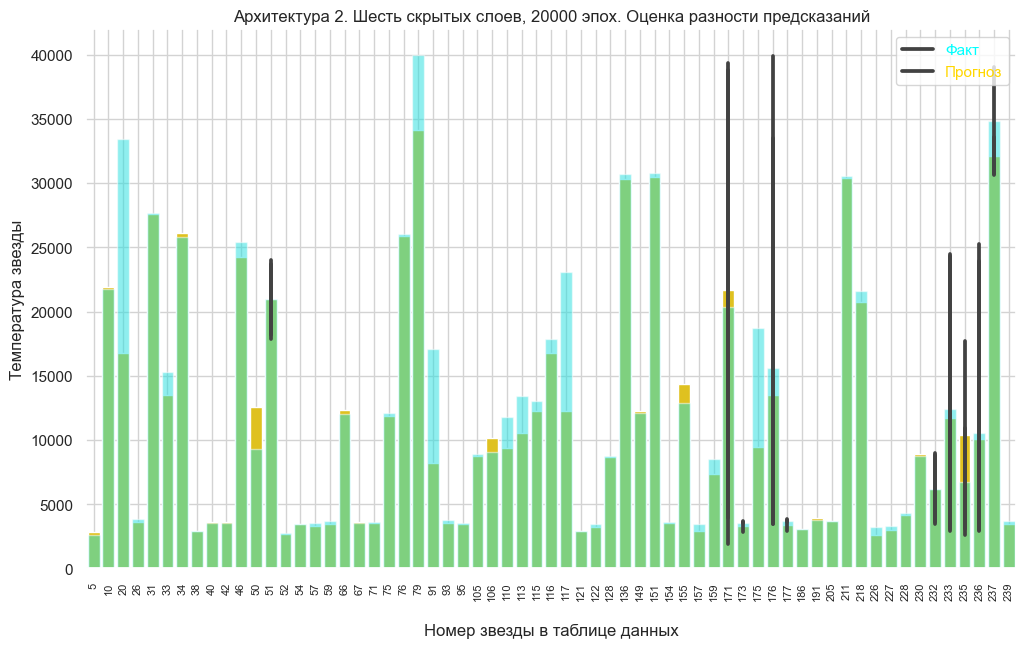

In [95]:
plt.subplots()
ax1 = sns.barplot(x=star_numbers, y=predicted_temperature, color='gold')
ax2 = sns.barplot(x=star_numbers, y=real_temperature,      color='cyan',alpha=0.5)
for bar in ax1.patches:
    bar.set_width(0.2)
for bar in ax2.patches:
    bar.set_width(0.8)    
sns.set(rc={'figure.figsize':(12,7)})
ax1.set_xlabel('\nНомер звезды в таблице данных')
ax1.set_ylabel('Температура звезды')
ax1.set_facecolor('white')
plt.grid(visible=True,color='lightgray' )
plt.legend(loc='upper right', labels=['Факт','Прогноз'],labelcolor=['cyan','gold'],facecolor='white')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.title(f'Архитектура 2. Шесть скрытых слоев, {num_epochs} эпох. Оценка разности предсказаний')
plt.show()

#### Базовая сеть: архитектура 3. Десять скрытых слоев

Третья модель с десятью скрытыми слоями, функции активации на всех скрытых слоях - ReLU, выходной - линейный (без функции активации).

In [96]:
class NET_10H(nn.Module):
    def __init__(self, neurons_in, 
                       neurons_hl_1, 
                       neurons_hl_2, 
                       neurons_hl_3, 
                       neurons_hl_4, 
                       neurons_hl_5,
                       neurons_hl_6,
                 
                       neurons_hl_7, 
                       neurons_hl_8, 
                       neurons_hl_9,
                       neurons_hl_10,
                 
                       neurons_out    ):
        super(NET_10H,self).__init__()
        self.fc1 = nn.Linear(neurons_in,neurons_hl_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(neurons_hl_1,neurons_hl_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(neurons_hl_2,neurons_hl_3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(neurons_hl_3,neurons_hl_4)
        self.act4 = nn.ReLU()
        
        self.fc5 = nn.Linear(neurons_hl_4,neurons_hl_5)
        self.act5 = nn.ReLU()
        self.fc6 = nn.Linear(neurons_hl_5,neurons_hl_6)
        self.act6 = nn.ReLU()
        
        self.fc7 = nn.Linear(neurons_hl_6,neurons_hl_7)
        self.act7 = nn.ReLU()
        self.fc8 = nn.Linear(neurons_hl_7,neurons_hl_8)
        self.act8 = nn.ReLU()
        self.fc9 = nn.Linear(neurons_hl_8,neurons_hl_9)
        self.act9 = nn.ReLU()
        self.fc10 = nn.Linear(neurons_hl_9,neurons_hl_10)
        self.act10 = nn.ReLU()

        self.fc_out = nn.Linear(neurons_hl_10,neurons_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)        
        x = self.fc6(x)
        x = self.act6(x)
        x = self.fc7(x)
        x = self.act7(x)
        x = self.fc8(x)
        x = self.act8(x)
        x = self.fc9(x)
        x = self.act9(x)
        x = self.fc10(x)
        x = self.act10(x)        
        x = self.fc_out(x)
        
        return x

In [97]:
neurons_hl_1 = round(X_train_processed.shape[1]* 0.8)
neurons_hl_2 = round(neurons_hl_1*   1)
neurons_hl_3 = round(neurons_hl_2*   1)
neurons_hl_4 = round(neurons_hl_3* 0.8)
neurons_hl_5 = round(neurons_hl_4* 0.9)
neurons_hl_6 = round(neurons_hl_5*   1)

neurons_hl_7 = round(neurons_hl_6*   1)
neurons_hl_8 = round(neurons_hl_7* 0.9)
neurons_hl_9 = round(neurons_hl_8* 0.8)
neurons_hl_10 = round(neurons_hl_9* 0.9)
neurons_out  = 1

In [98]:
print(f"Число нейронов в слоях сети третьей архитектуры (10 скрытых слоев):")
print(f"neurons_hl_1: {neurons_hl_1}")
print(f"neurons_hl_2: {neurons_hl_2}")
print(f"neurons_hl_3: {neurons_hl_3}")
print(f"neurons_hl_4: {neurons_hl_4}")
print(f"neurons_hl_5: {neurons_hl_5}")
print(f"neurons_hl_6: {neurons_hl_6}")

print(f"neurons_hl_7: {neurons_hl_7}")
print(f"neurons_hl_8: {neurons_hl_8}")
print(f"neurons_hl_9: {neurons_hl_9}")
print(f"neurons_hl_10:{neurons_hl_10}")
print(f"neurons_out:  {neurons_out}")

Число нейронов в слоях сети третьей архитектуры (10 скрытых слоев):
neurons_hl_1: 14
neurons_hl_2: 14
neurons_hl_3: 14
neurons_hl_4: 11
neurons_hl_5: 10
neurons_hl_6: 10
neurons_hl_7: 10
neurons_hl_8: 9
neurons_hl_9: 7
neurons_hl_10:6
neurons_out:  1


In [99]:
net_10h = NET_10H(neurons_in, 
                  neurons_hl_1, 
                  neurons_hl_2, 
                  neurons_hl_3, 
                  neurons_hl_4, 
                  neurons_hl_5, 
                  neurons_hl_6, 
                  neurons_hl_7, 
                  neurons_hl_8, 
                  neurons_hl_9, 
                  neurons_hl_10, 
                  neurons_out)

In [100]:
num_epochs = 40000
test_every = round(num_epochs/20)
loss       = nn.MSELoss()
optimizer  = torch.optim.Adam(net_10h.parameters(), lr=1e-3)

mse_test = nn.MSELoss()

In [101]:
%%time
best_rmse = 1000000
best_batch_size = 0
best_epoch = 0
best_net = 0
metrics = []

print(f"Архитектура 3 (10 скрытых слоев). Запуск обучения в {num_epochs} эпох. Тестирование раз в {test_every} эпох")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net_10h.forward(X_train).flatten()
    
    loss_value = loss(preds, y_train)

    loss_value.backward()
    
    optimizer.step()
    
    if epoch % test_every == 0 or epoch == num_epochs - 1:
        net_10h.eval()
        test_preds = net_10h.forward(X_valid)
        trmse = mean_squared_error(y_valid.detach().numpy() , test_preds.detach().numpy()) ** 0.5
        print(f"Эпоха {epoch} rmse =",trmse)        
        metrics.append(trmse)
        if trmse < best_rmse:
            best_rmse = trmse
            best_epoch = epoch
            best_net = net_10h
        if trmse > best_rmse *1.2:
            break
            
best_results.append({'hidden layers':10,
                     'layers':[neurons_in,neurons_hl_1, neurons_hl_2, neurons_hl_3, neurons_hl_4, neurons_hl_5, neurons_hl_6, neurons_hl_7, neurons_hl_8, neurons_hl_9, neurons_hl_10, neurons_out],
                     'epoch':best_epoch,
                     'rmse':best_rmse,
                     'median_metric': np.median(metrics),
                     'mean_metric':np.mean(metrics),
                     'best_net':best_net
                    })

print("Обучение завершено")

Архитектура 3 (10 скрытых слоев). Запуск обучения в 40000 эпох. Тестирование раз в 2000 эпох
Эпоха 0 rmse = 16654.154556746493
Эпоха 2000 rmse = 4888.172869283573
Эпоха 4000 rmse = 2803.992956481881
Эпоха 6000 rmse = 2257.505592462619
Эпоха 8000 rmse = 1987.97541483792
Эпоха 10000 rmse = 1936.691831448669
Эпоха 12000 rmse = 2027.162548983184
Эпоха 14000 rmse = 2121.099125453594
Эпоха 16000 rmse = 2158.3919940548335
Эпоха 18000 rmse = 2194.4209942488246
Эпоха 20000 rmse = 2214.7923153198813
Эпоха 22000 rmse = 2245.212907498975
Эпоха 24000 rmse = 2245.813327059932
Эпоха 26000 rmse = 2233.821725205483
Эпоха 28000 rmse = 2247.895682632982
Эпоха 30000 rmse = 2253.226797284286
Эпоха 32000 rmse = 2299.953912581728
Эпоха 34000 rmse = 2351.8312014258167
Обучение завершено
CPU times: total: 36.3 s
Wall time: 37.1 s


Построим график 

In [102]:
star_numbers          = list(df_train.iloc[list(X_valid_source.index)]['ind'])
predicted_temperature = test_preds.detach().numpy().reshape(-1)
real_temperature      = y_valid.detach().numpy()

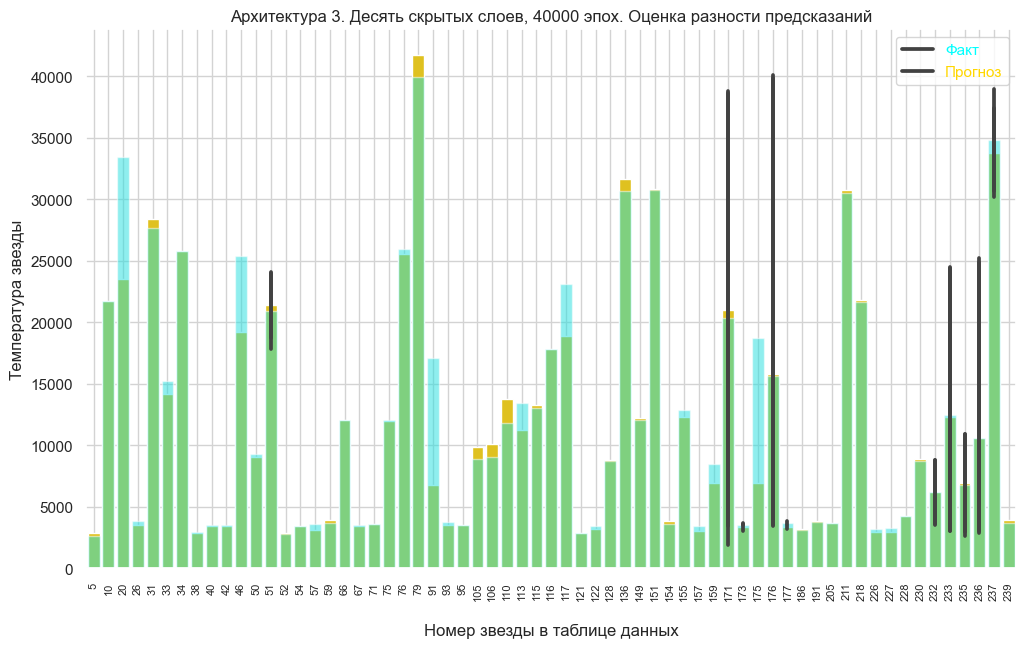

In [103]:
plt.subplots()
ax1 = sns.barplot(x=star_numbers, y=predicted_temperature, color='gold')
ax2 = sns.barplot(x=star_numbers, y=real_temperature,      color='cyan',alpha=0.5)
for bar in ax1.patches:
    bar.set_width(0.2)
for bar in ax2.patches:
    bar.set_width(0.8)    
sns.set(rc={'figure.figsize':(12,7)})
ax1.set_xlabel('\nНомер звезды в таблице данных')
ax1.set_ylabel('Температура звезды')
ax1.set_facecolor('white')
plt.grid(visible=True,color='lightgray' )
plt.legend(loc='upper right', labels=['Факт','Прогноз'],labelcolor=['cyan','gold'],facecolor='white')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.title(f'Архитектура 3. Десять скрытых слоев, {num_epochs} эпох. Оценка разности предсказаний')
plt.show()

#### Базовая сеть: архитектура 4. Один скрытый слой

Четвертая модель с одним скрытым слоем, функции активации на всех скрытых слоях - ReLU, на выходном - Linear

In [104]:
class NET_1H(nn.Module):
    def __init__(self, neurons_in, 
                       neurons_hl_1, 
                       neurons_out    ):
        super(NET_1H,self).__init__()
        self.fc1 = nn.Linear(neurons_in,neurons_hl_1)
        self.act1 = nn.LeakyReLU()
        self.fc_out = nn.Linear(neurons_hl_1,neurons_out)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc_out(x)
        return x

In [105]:
neurons_hl_1 = round(X_train_processed.shape[1]* 0.8)
neurons_out  = 1

In [106]:
print(f"Число нейронов в слоях сети четвертой архитектуры (1 скрытый слой):")
print(f"neurons_in: {neurons_in}")
print(f"neurons_hl_1: {neurons_hl_1}")
print(f"neurons_out: {neurons_out}")

Число нейронов в слоях сети четвертой архитектуры (1 скрытый слой):
neurons_in: 18
neurons_hl_1: 14
neurons_out: 1


In [107]:
net_1h = NET_1H(neurons_in, 
                neurons_hl_1, 
                neurons_out)

In [108]:
num_epochs = 300000
test_every = round(num_epochs/20)
loss       = nn.MSELoss()
optimizer  = torch.optim.Adam(net_1h.parameters(), lr=1e-3)

mse_test = nn.MSELoss()

In [109]:
%%time
best_rmse = 1000000
best_batch_size = 0
best_epoch = 0
best_net = 0
metrics = []

print(f"Архитектура 4 (1 скрытый слой). Запуск обучения в {num_epochs} эпох. Тестирование раз в {test_every} эпох")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net_1h.forward(X_train).flatten()
    
    loss_value = loss(preds, y_train)

    loss_value.backward()
    
    optimizer.step()
    
    if epoch % test_every == 0 or epoch == num_epochs - 1:
        net_1h.eval()
        test_preds = net_1h.forward(X_valid)
        trmse = mean_squared_error(y_valid.detach().numpy() , test_preds.detach().numpy()) ** 0.5
        print(f"Эпоха {epoch} rmse =",trmse)
        metrics.append(trmse)
        if trmse < best_rmse:
            best_rmse = trmse
            best_epoch = epoch
            best_net = net_1h
        if trmse > best_rmse *1.2:
            break
            
best_results.append({'hidden layers':1,
                     'layers':[neurons_in,neurons_hl_1, neurons_out],
                     'epoch':best_epoch,
                     'rmse':best_rmse,
                     'median_metric': np.median(metrics),
                     'mean_metric':np.mean(metrics),
                     'best_net':best_net
                    })       

print("Обучение завершено")

Архитектура 4 (1 скрытый слой). Запуск обучения в 300000 эпох. Тестирование раз в 15000 эпох
Эпоха 0 rmse = 16654.141106643718
Эпоха 15000 rmse = 10095.524949203978
Эпоха 30000 rmse = 7085.90036622023
Эпоха 45000 rmse = 5501.297665096845
Эпоха 60000 rmse = 5225.899348437549
Эпоха 75000 rmse = 5166.32345096588
Эпоха 90000 rmse = 5107.145974025023
Эпоха 105000 rmse = 5093.229820065064
Эпоха 120000 rmse = 4894.630731730434
Эпоха 135000 rmse = 4656.285214631939
Эпоха 150000 rmse = 4530.83060817771
Эпоха 165000 rmse = 4458.269843784694
Эпоха 180000 rmse = 4410.430817958717
Эпоха 195000 rmse = 4351.357029709237
Эпоха 210000 rmse = 4266.159865734054
Эпоха 225000 rmse = 4208.30631014426
Эпоха 240000 rmse = 4162.38705552475
Эпоха 255000 rmse = 4116.471304406238
Эпоха 270000 rmse = 4041.2533946784383
Эпоха 285000 rmse = 3928.2279719995886
Эпоха 299999 rmse = 3847.327643962755
Обучение завершено
CPU times: total: 1min 39s
Wall time: 1min 37s


Построим график 

In [110]:
star_numbers          = list(df_train.iloc[list(X_valid_source.index)]['ind'])
predicted_temperature = test_preds.detach().numpy().reshape(-1)
real_temperature      = y_valid.detach().numpy()

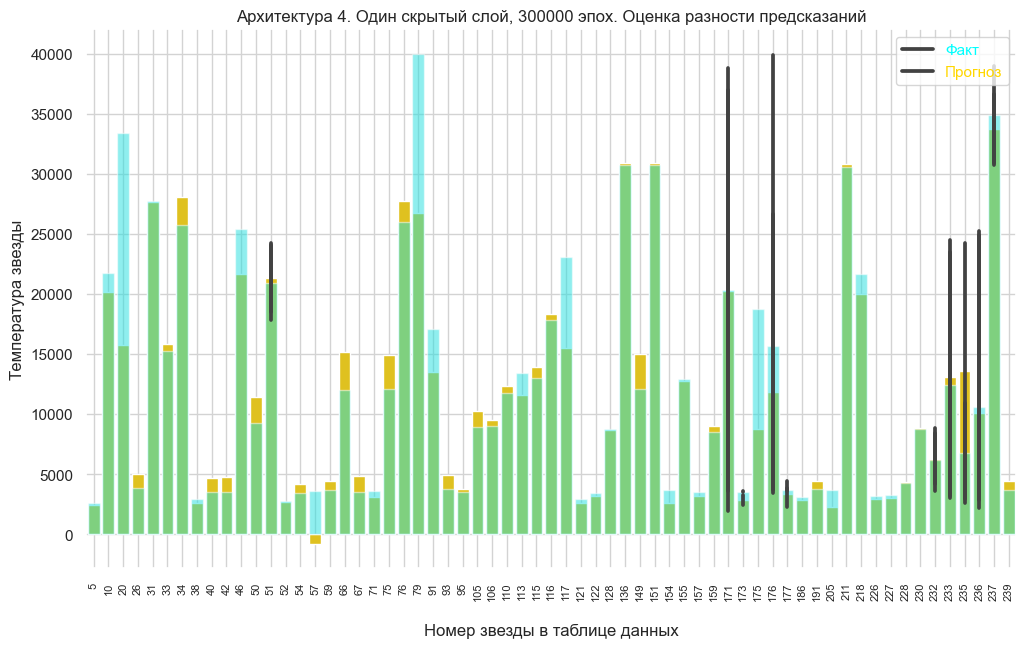

In [111]:
plt.subplots()
ax1 = sns.barplot(x=star_numbers, y=predicted_temperature, color='gold')
ax2 = sns.barplot(x=star_numbers, y=real_temperature,      color='cyan',alpha=0.5)
for bar in ax1.patches:
    bar.set_width(0.2)
for bar in ax2.patches:
    bar.set_width(0.8)    
sns.set(rc={'figure.figsize':(12,7)})
ax1.set_xlabel('\nНомер звезды в таблице данных')
ax1.set_ylabel('Температура звезды')
ax1.set_facecolor('white')
plt.grid(visible=True,color='lightgray' )
plt.legend(loc='upper right', labels=['Факт','Прогноз'],labelcolor=['cyan','gold'],facecolor='white')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.title(f'Архитектура 4. Один скрытый слой, {num_epochs} эпох. Оценка разности предсказаний')
plt.show()

#### Базовая сеть: архитектура 5. Два скрытых слоя

In [112]:
class NET_2H(nn.Module):
    def __init__(self, neurons_in, 
                       neurons_hl_1, 
                       neurons_hl_2, 
                       neurons_out    ):
        super(NET_2H,self).__init__()
        self.fc1 = nn.Linear(neurons_in,neurons_hl_1)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(neurons_hl_1,neurons_hl_2)
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(neurons_hl_2,neurons_out)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [113]:
neurons_hl_1 = round(X_train_processed.shape[1]* 1.2)
neurons_hl_2 = round(neurons_hl_1* 0.5)
neurons_out  = 1

In [114]:
print(f"Число нейронов в слоях сети пятой архитектуры (2 скрытых слоя):")
print(f"neurons_in: {neurons_in}")
print(f"neurons_hl_1: {neurons_hl_1}")
print(f"neurons_hl_2: {neurons_hl_2}")
print(f"neurons_out: {neurons_out}")

Число нейронов в слоях сети пятой архитектуры (2 скрытых слоя):
neurons_in: 18
neurons_hl_1: 22
neurons_hl_2: 11
neurons_out: 1


In [115]:
net_2h = NET_2H(neurons_in, 
                neurons_hl_1, 
                neurons_hl_2, 
                neurons_out)

In [116]:
num_epochs = 100000
test_every = round(num_epochs/20)
loss       = nn.MSELoss()
optimizer  = torch.optim.Adam(net_2h.parameters(), lr=1e-3)

mse_test = nn.MSELoss()

In [117]:
%%time
best_rmse = 1000000
best_batch_size = 0
best_epoch = 0
best_net = 0
metrics = []

print(f"Архитектура 5 (2 скрытых слоя). Запуск обучения в {num_epochs} эпох. Тестирование раз в {test_every} эпох")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net_2h.forward(X_train).flatten()
    
    loss_value = loss(preds, y_train)

    loss_value.backward()
    
    optimizer.step()
    
    if epoch % test_every == 0 or epoch == num_epochs - 1:
        net_2h.eval()
        test_preds = net_2h.forward(X_valid)
        trmse = mean_squared_error(y_valid.detach().numpy() , test_preds.detach().numpy()) ** 0.5
        print(f"Эпоха {epoch} rmse =",trmse)
        metrics.append(trmse)
        if trmse < best_rmse:
            best_rmse = trmse
            best_epoch = epoch
            best_net = net_2h
        if trmse > best_rmse *1.2:
            break
            
best_results.append({'hidden layers':2,
                     'layers':[neurons_in,neurons_hl_1, neurons_hl_2, neurons_out],
                     'epoch':best_epoch,
                     'rmse':best_rmse,
                     'median_metric': np.median(metrics),
                     'mean_metric':np.mean(metrics),
                     'best_net':best_net
                    })

print("Обучение завершено")

Архитектура 5 (2 скрытых слоя). Запуск обучения в 100000 эпох. Тестирование раз в 5000 эпох
Эпоха 0 rmse = 16654.021976687793
Эпоха 5000 rmse = 12826.352248398607
Эпоха 10000 rmse = 7626.804048879189
Эпоха 15000 rmse = 4701.308328540046
Эпоха 20000 rmse = 4181.7651775297
Эпоха 25000 rmse = 3952.5587914666116
Эпоха 30000 rmse = 3742.964734004316
Эпоха 35000 rmse = 3510.8328071840733
Эпоха 40000 rmse = 3214.2818793627916
Эпоха 45000 rmse = 2911.9615382075363
Эпоха 50000 rmse = 2702.9386785497004
Эпоха 55000 rmse = 2725.7533820945723
Эпоха 60000 rmse = 3007.038077577336
Эпоха 65000 rmse = 3240.86793930268
Эпоха 70000 rmse = 3457.08865955156
Обучение завершено
CPU times: total: 32.1 s
Wall time: 31.7 s


Построим график 

In [118]:
star_numbers          = list(df_train.iloc[list(X_valid_source.index)]['ind'])
predicted_temperature = test_preds.detach().numpy().reshape(-1)
real_temperature      = y_valid.detach().numpy()

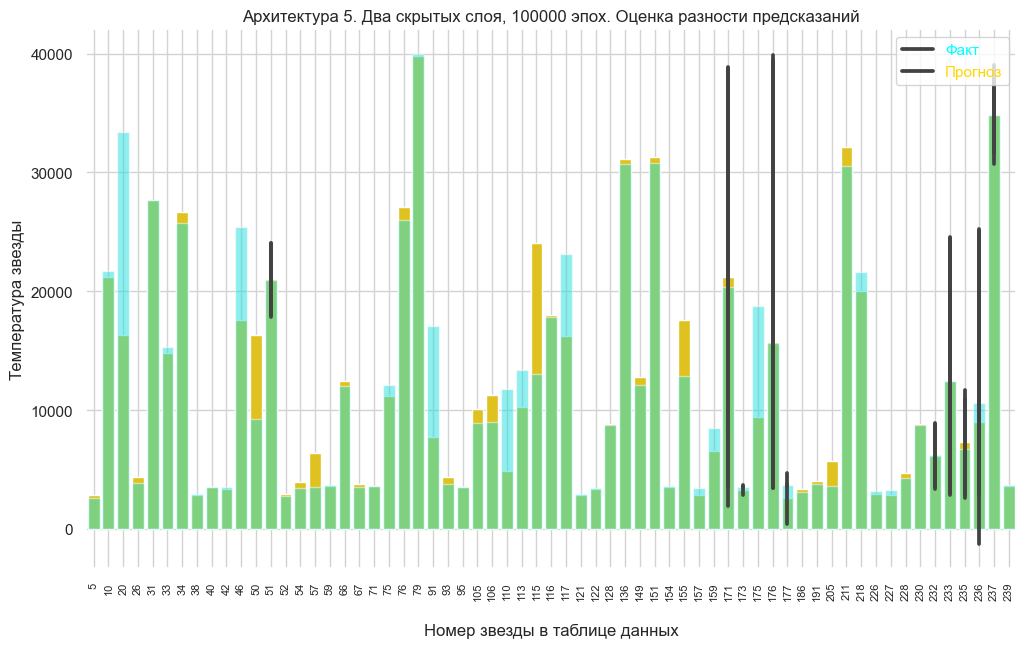

In [119]:
plt.subplots()
ax1 = sns.barplot(x=star_numbers, y=predicted_temperature, color='gold')
ax2 = sns.barplot(x=star_numbers, y=real_temperature,      color='cyan',alpha=0.5)
for bar in ax1.patches:
    bar.set_width(0.2)
for bar in ax2.patches:
    bar.set_width(0.8)    
sns.set(rc={'figure.figsize':(12,7)})
ax1.set_xlabel('\nНомер звезды в таблице данных')
ax1.set_ylabel('Температура звезды')
ax1.set_facecolor('white')
plt.grid(visible=True,color='lightgray' )
plt.legend(loc='upper right', labels=['Факт','Прогноз'],labelcolor=['cyan','gold'],facecolor='white')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.title(f'Архитектура 5. Два скрытых слоя, {num_epochs} эпох. Оценка разности предсказаний')
plt.show()

#### Базовая сеть: архитектура 6. Три скрытых слоя

In [120]:
class NET_3H(nn.Module):
    def __init__(self, neurons_in, 
                       neurons_hl_1, 
                       neurons_hl_2, 
                       neurons_hl_3, 
                       neurons_out    ):
        super(NET_3H,self).__init__()
        self.fc1 = nn.Linear(neurons_in,neurons_hl_1)
        self.act1 = nn.Sigmoid()        
        self.fc2 = nn.Linear(neurons_hl_1,neurons_hl_2)
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(neurons_hl_2,neurons_hl_3)
        self.act3 = nn.LeakyReLU()
        self.fc4 = nn.Linear(neurons_hl_3,neurons_out)
  
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        return x

In [121]:
neurons_hl_1 = round(X_train_processed.shape[1]* 1.2)
neurons_hl_2 = round(neurons_hl_1* 0.5)
neurons_hl_3 = round(neurons_hl_2* 0.2)
neurons_out  = 1

In [122]:
print(f"Число нейронов в слоях сети шестой архитектуры (3 скрытых слоя):")
print(f"neurons_in: {neurons_in}")
print(f"neurons_hl_1: {neurons_hl_1}")
print(f"neurons_hl_2: {neurons_hl_2}")
print(f"neurons_hl_3: {neurons_hl_3}")
print(f"neurons_out: {neurons_out}")

Число нейронов в слоях сети шестой архитектуры (3 скрытых слоя):
neurons_in: 18
neurons_hl_1: 22
neurons_hl_2: 11
neurons_hl_3: 2
neurons_out: 1


In [123]:
net_3h= 0
net_3h = NET_3H(neurons_in, 
                neurons_hl_1, 
                neurons_hl_2, 
                neurons_hl_3, 
                neurons_out)

In [124]:
num_epochs = 55000
test_every = round(num_epochs/20)
loss       = nn.MSELoss()
optimizer = 0
optimizer  = torch.optim.Adam(net_3h.parameters(), lr=1e-3)

mse_test = nn.MSELoss()

In [125]:
%%time
best_rmse = 1000000
best_batch_size = 0
best_epoch = 0
best_net = 0
metrics = []

print(f"Архитектура 6 (3 скрытых слоя). Запуск обучения в {num_epochs} эпох. Тестирование раз в {test_every} эпох")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net_3h.forward(X_train).flatten()
    
    loss_value = loss(preds, y_train)

    loss_value.backward()
    
    optimizer.step()
    
    if epoch % test_every == 0 or epoch == num_epochs - 1:
        net_3h.eval()
        test_preds = net_3h.forward(X_valid)
        trmse = mean_squared_error(y_valid.detach().numpy() , test_preds.detach().numpy()) ** 0.5
        print(f"Эпоха {epoch} rmse =",trmse)
        metrics.append(trmse)
        if trmse < best_rmse:
            best_rmse = trmse
            best_epoch = epoch
            best_net = net_3h
        if trmse > best_rmse *1.3:
            break
            
best_results.append({'hidden layers':3,
                     'layers':[neurons_in,neurons_hl_1, neurons_hl_2, neurons_hl_3, neurons_out],
                     'epoch':best_epoch,
                     'rmse':best_rmse,
                     'median_metric': np.median(metrics),
                     'mean_metric':np.mean(metrics),
                     'best_net':best_net
                    })

print("Обучение завершено")

Архитектура 6 (3 скрытых слоя). Запуск обучения в 55000 эпох. Тестирование раз в 2750 эпох
Эпоха 0 rmse = 16654.382246123692
Эпоха 2750 rmse = 11015.788305881699
Эпоха 5500 rmse = 5639.50068711761
Эпоха 8250 rmse = 4723.909397945731
Эпоха 11000 rmse = 4401.763510230871
Эпоха 13750 rmse = 4165.447875078981
Эпоха 16500 rmse = 3909.5219656628096
Эпоха 19250 rmse = 3629.204044966334
Эпоха 22000 rmse = 3064.829359034529
Эпоха 24750 rmse = 2979.819625413592
Эпоха 27500 rmse = 3449.712741664152
Эпоха 30250 rmse = 3612.1895022271465
Эпоха 33000 rmse = 3757.4521953046856
Эпоха 35750 rmse = 3623.9711643444407
Эпоха 38500 rmse = 3920.192469764718
Обучение завершено
CPU times: total: 20.8 s
Wall time: 20.7 s


Построим график 

In [126]:
star_numbers          = list(df_train.iloc[list(X_valid_source.index)]['ind'])
predicted_temperature = test_preds.detach().numpy().reshape(-1)
real_temperature      = y_valid.detach().numpy()

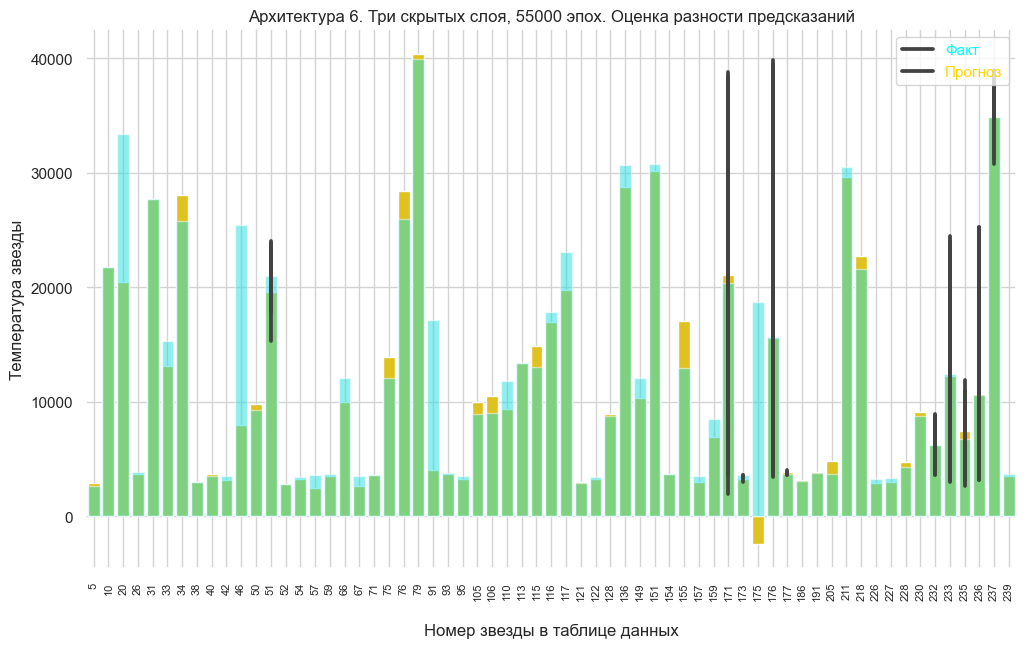

In [127]:
plt.subplots()
ax1 = sns.barplot(x=star_numbers, y=predicted_temperature, color='gold')
ax2 = sns.barplot(x=star_numbers, y=real_temperature,      color='cyan',alpha=0.5)
for bar in ax1.patches:
    bar.set_width(0.2)
for bar in ax2.patches:
    bar.set_width(0.8)    
sns.set(rc={'figure.figsize':(12,7)})
ax1.set_xlabel('\nНомер звезды в таблице данных')
ax1.set_ylabel('Температура звезды')
ax1.set_facecolor('white')
plt.grid(visible=True,color='lightgray' )
plt.legend(loc='upper right', labels=['Факт','Прогноз'],labelcolor=['cyan','gold'],facecolor='white')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.title(f'Архитектура 6. Три скрытых слоя, {num_epochs} эпох. Оценка разности предсказаний')
plt.show()

#### Вывод.

In [128]:
df_base_results = pd.DataFrame(best_results).sort_values(by=['rmse','median_metric'])

In [129]:
df_base_results.drop(columns=['best_net'])

,hidden layers,layers,epoch,rmse,median_metric,mean_metric
2,10,"[18, 14, 14, 14, 11, 10, 10, 10, 9, 7, 6, 1]",10000,1936.691831448669,2245.5131172794536,3173.45087516726
4,2,"[18, 22, 11, 1]",50000,2702.9386785497004,3510.8328071840733,5230.435884489101
0,4,"[18, 14, 11, 9, 7, 1]",29999,2795.989091538091,4004.1092642434223,4596.385772342134
5,3,"[18, 22, 11, 2, 1]",24750,2979.819625413592,3909.5219656628096,5236.512339384066
1,6,"[18, 14, 11, 11, 11, 9, 7, 1]",19000,3040.535972489061,3529.83200733406,4382.732668671281
3,1,"[18, 14, 1]",299999,3847.327643962755,4530.83060817771,5514.352403481004


Из рассмотренных архитектур на валидации наилучшую метрику выдает архитектура с двумя скрытыми слоями. Посмотрим насколько отличается метрика на тестовых данных

In [130]:
for i in range(6):
    hidden_layers = df_base_results.iloc[ i]['hidden layers']
    model = df_base_results.iloc[ i]['best_net']
    test_preds = model.forward(X_test)
    trmse = mean_squared_error(y_test.detach().numpy() , test_preds.detach().numpy()) ** 0.5
    print(f"Число скрытых слоев {hidden_layers}, тестовая RMSE = {trmse}")

Число скрытых слоев 10, тестовая RMSE = 3757.174470263525
Число скрытых слоев 2, тестовая RMSE = 8739.654455411839
Число скрытых слоев 4, тестовая RMSE = 5440.270765320417
Число скрытых слоев 3, тестовая RMSE = 26147.86385156539
Число скрытых слоев 6, тестовая RMSE = 4184.989366772633
Число скрытых слоев 1, тестовая RMSE = 4478.363317105926


## Улучшение нейронной сети

Так как архитектура с четыремя слоями показала себя лучше остальных как на валидационной выборке, так и на тестовой, будем пытаться улучшить именно её.
Попробуем:
- Добавим разбиение на батчи
- Добавим dropout

In [131]:
neurons_hl_1 = round(X_train_processed.shape[1]* 0.8)
neurons_out  = 1
neurons_hl_3 = round(neurons_hl_2* 0.8)
neurons_hl_4 = round(neurons_hl_3* 0.8)
neurons_out  = 1

In [132]:
class NET(nn.Module):
    def __init__(self, neurons_in, 
                       neurons_hl_1, 
                       neurons_hl_2, 
                       neurons_hl_3, 
                       neurons_hl_4, 
                       neurons_out ,
                       dropout_set = [0,0,0,0,0,0]
                ):
        super(NET,self).__init__()
        self.dropout_set = dropout_set
        self.fc1 = nn.Linear(neurons_in,neurons_hl_1)
        self.act1 = nn.ReLU()
        if self.dropout_set[0] != 0:
            self.dp1 = nn.Dropout(p=dropout_set[0])
        self.fc2 = nn.Linear(neurons_hl_1,neurons_out)
            
        self.fc2 = nn.Linear(neurons_hl_1,neurons_hl_2)
        self.act2 = nn.ReLU()
        if self.dropout_set[1] != 0:
            self.dp2 = nn.Dropout(p=dropout_set[1])
        self.fc3 = nn.Linear(neurons_hl_2,neurons_hl_3)
        self.act3 = nn.ReLU()
        if self.dropout_set[2] != 0:
            self.dp3 = nn.Dropout(p=dropout_set[2])
        self.fc4 = nn.Linear(neurons_hl_3,neurons_hl_4)
        self.act4 = nn.ReLU()
        if self.dropout_set[3] != 0:
            self.dp4 = nn.Dropout(p=dropout_set[3])        
        self.fc5 = nn.Linear(neurons_hl_4,neurons_out)
        self.act5 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        if self.dropout_set[0] != 0:
            x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        if self.dropout_set[1] != 0:
            x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        if self.dropout_set[2] != 0:
            x = self.dp3(x)        
        x = self.fc4(x)
        x = self.act4(x)
        if self.dropout_set[3] != 0:
            x = self.dp4(x)        
        x = self.fc5(x)
        x = self.act5(x)
        return x

In [133]:
print(f"Число нейронов в слоях сети:")
print(f"neurons_hl_1: {neurons_hl_1}")
print(f"neurons_hl_2: {neurons_hl_2}")
print(f"neurons_hl_3: {neurons_hl_3}")
print(f"neurons_hl_4: {neurons_hl_4}")
print(f"neurons_out: {neurons_out}")

Число нейронов в слоях сети:
neurons_hl_1: 14
neurons_hl_2: 11
neurons_hl_3: 9
neurons_hl_4: 7
neurons_out: 1


In [134]:
%%time
num_epochs = 30000
test_every = round(num_epochs/20)

batch_size_min = 30
batch_size_max = 120
batch_sizes = [i for i in range(batch_size_min,batch_size_max,10)]

best_rmse = 1000000
best_batch_size = 0
best_epoch = 0
best_dropout_set = list()
metrics = []

# создаем наборы значений для Dropout. Каждое число соответствует 
# конкретному скрытому слою, попробуем несколько таких наборов
dropout_sets = list()
# номер слоя:          1    2    3    4  

dropout_sets.append([  0,   0,   0,   0])
dropout_sets.append([  0, 0.6,   0,   0])
dropout_sets.append([  0,   0, 0.8,   0])
dropout_sets.append([0.7, 0.2,   0,   0])

for do_set in dropout_sets:
    best_do_set_metric = 1000000
    best_do_set_batch_size = 0
    best_do_set_model = 0
    
    for batch_size in batch_sizes:
        num_batches = ceil(len(X_train)/batch_size)

        net = NET(  neurons_in, 
                    neurons_hl_1, 
                    neurons_hl_2, 
                    neurons_hl_3, 
                    neurons_hl_4, 
                    neurons_out,
                    do_set
                 )

        loss       = nn.MSELoss()
        optimizer  = torch.optim.Adam(net.parameters(), lr=1e-3)
        mse_test   = nn.MSELoss()
        
        not_getting_better_loops = 0
        loop_best_rmse = 1000000
        for epoch in range(num_epochs):
            order = np.random.permutation(len(X_train))
            for batch_index in range(num_batches):
                start_index = batch_index * batch_size
                optimizer.zero_grad()

                batch_indexes = order[start_index:start_index + batch_size]
                X_batch = X_train[batch_indexes]
                y_batch = y_train[batch_indexes]

                preds = net.forward(X_batch).flatten()

                loss_value = loss(preds, y_batch)

                loss_value.backward()

                optimizer.step()

            if epoch % 100 == 0 or epoch == num_epochs - 1:
                net.eval()
                test_preds = net.forward(X_valid)
                trmse = mean_squared_error(y_valid.detach().numpy() , test_preds.detach().numpy()) ** 0.5
                print(f"dropout_set: {do_set}, batch_size: {batch_size}, эпоха {epoch} rmse ~",round(trmse))
                if trmse < best_rmse:
                    best_rmse = trmse
                    best_batch_size = batch_size
                    best_epoch = epoch
                    best_dropout_set = do_set
                    best_model = net 
                if trmse < best_do_set_metric:
                    best_do_set_metric = trmse
                    best_do_set_batch_size = batch_size
                    best_do_set_model = net 
                if trmse > loop_best_rmse:
                    not_getting_better_loops += 1
                    if not_getting_better_loops >= 18:
                        break
                else:
                    not_getting_better_loops = 0
                    loop_best_rmse = trmse
    metrics.append({'dropout_set':do_set,
                    'batch_size' :best_batch_size,
                    'validation_metric':best_do_set_metric,
                    'best_do_set_model':best_do_set_model
                   })
            

print("Обучение завершено")
print(f"Лучший результат: RMSE = {best_rmse}")
print("При показателях:")
print(f"Размер батча: {best_batch_size}")
print(f"коэффициенты Dropout для скрытых слоев: {best_dropout_set}")
print(f"на эпохе: {best_epoch}")

dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 0 rmse ~ 16654
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 100 rmse ~ 8116
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 200 rmse ~ 6758
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 300 rmse ~ 5504
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 400 rmse ~ 5098
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 500 rmse ~ 5122
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 600 rmse ~ 5157
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 700 rmse ~ 5180
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 800 rmse ~ 5146
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 900 rmse ~ 5149
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 1000 rmse ~ 5184
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 1100 rmse ~ 5147
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 1200 rmse ~ 5198
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 1300 rmse ~ 5200
dropout_set: [0, 0, 0, 0], batch_size: 30, эпоха 1400 rmse ~ 5199
dropout_set: [0, 0, 0

In [137]:
df_metrics = pd.DataFrame(data=metrics).sort_values(by='validation_metric').reset_index(drop=True)

In [140]:
test_rmse = []
best_model = 0
best_metric = 999999
best_dropouts = ''
best_preds = []
best_batch_size = 0
for i in range(4):
    best = df_metrics.iloc[i]
    model = best['best_do_set_model']
    dropouts   = best['dropout_set' ]
    valid      = best['validation_metric' ]
    batch_size = best['batch_size' ]
    test_preds = model.forward(X_test)
    trmse = mean_squared_error(y_test.detach().numpy() , test_preds.detach().numpy()) ** 0.5
    test_rmse.append(trmse)
    if trmse < best_metric:
        best_model = model
        best_metric= trmse
        best_valid = valid
        best_dropouts = dropouts
        best_preds = test_preds
        best_batch_size = batch_size
df_metrics['test_rmse'] = round(pd.Series(test_rmse),0)
df_metrics['validation_metric'] = round(df_metrics['validation_metric'],0)

#### Выводы по тюнингу модели:

Добавив разбиение на батчи и dropout получем следующие результаты расчетов

In [141]:
df_metrics.drop(columns=['best_do_set_model']).rename(columns={'validation_metric':'valid_metric'})

,dropout_set,batch_size,valid_metric,test_rmse
0,"[0, 0.6, 0, 0]",40,3077.0,4083.0
1,"[0, 0, 0.8, 0]",40,3483.0,5832.0
2,"[0, 0, 0, 0]",60,3758.0,4297.0
3,"[0.7, 0.2, 0, 0]",40,4200.0,3908.0


In [142]:
test_preds = best_model.forward(X_test)
trmse = mean_squared_error(y_test.detach().numpy() , test_preds.detach().numpy()) ** 0.5
print_html('<h3>Лучшая модель:</h3>')
print_html('Число скрытых слоев: <strong>4</strong>')
print_html(f'параметры Dropout по слоям: <strong>{best_dropouts}</strong>')
print_html(f'Размер батча: <strong>{best_batch_size}</strong>')
print_html(f'RMSE на валидационной выборке: <strong>{round(best_valid)}</strong>')
print_html(f'RMSE на тестовой выборке: <strong>{round(best_metric)}</strong>')
print_html('<BR>')

In [143]:
star_numbers          = list(df_test['ind'])
predicted_temperature = best_preds.detach().numpy().reshape(-1)
real_temperature      = y_test.detach().numpy()

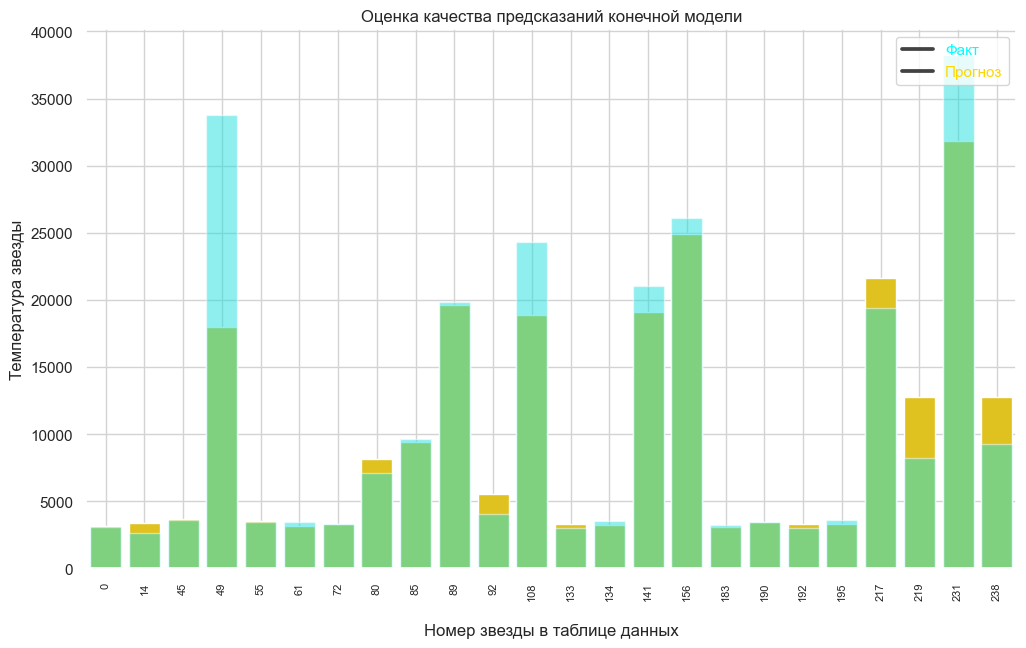

In [144]:
plt.subplots()
ax1 = sns.barplot(x=star_numbers, y=predicted_temperature, color='gold')
ax2 = sns.barplot(x=star_numbers, y=real_temperature,      color='cyan',alpha=0.5)
for bar in ax1.patches:
    bar.set_width(0.2)
for bar in ax2.patches:
    bar.set_width(0.8)    
sns.set(rc={'figure.figsize':(12,7)})
ax1.set_xlabel('\nНомер звезды в таблице данных')
ax1.set_ylabel('Температура звезды')
ax1.set_facecolor('white')
plt.grid(visible=True,color='lightgray' )
plt.legend(loc='upper right', labels=['Факт','Прогноз'],labelcolor=['cyan','gold'],facecolor='white')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.title(f'Оценка качества предсказаний конечной модели')
plt.show()

Хотя dropout слои и не оказались полезны, однако же использование батчей дало небольшое улучшение метрики.
Дальнейшее увеличение можно было бы получить при увелчении начального датасета.

## Выводы

Были опробованы несколько базовых архитектур нейронных сетей, характеристики которых отражены в табличке.

In [145]:
df_base_results.rename(columns={'hidden layers':'Число скрытых слоев',
                                'layers':'Количество нейронов по слоям',
                                'epoch':'Число эпох',
                                'rmse':'RMSE на валидации'
                                }).drop(columns=['median_metric','mean_metric','best_net'])

,Число скрытых слоев,Количество нейронов по слоям,Число эпох,RMSE на валидации
2,10,"[18, 14, 14, 14, 11, 10, 10, 10, 9, 7, 6, 1]",10000,1936.691831448669
4,2,"[18, 22, 11, 1]",50000,2702.9386785497004
0,4,"[18, 14, 11, 9, 7, 1]",29999,2795.989091538091
5,3,"[18, 22, 11, 2, 1]",24750,2979.819625413592
1,6,"[18, 14, 11, 11, 11, 9, 7, 1]",19000,3040.535972489061
3,1,"[18, 14, 1]",299999,3847.327643962755


<strong>Архитектура 1: 4 скрытых слоя</strong><BR>
Первоначальная архитектура была выбрана на обум, но как оказалось, показала наилучшие результаты, вследствие чего и была выбрана в качестве основной. На валидационной выборке метрика очень хорошая, но на тестовой похуже, что возможно говорит о некотором переобучении<BR>
<strong>Архитектура 2: 6 скрытых слоев</strong><BR>
Данная архитектура тоже делалась на угад. Результат на валидационной выборке неплохой, но на тестовой куда хуже. Учитывая незамысловатость задачи шесть слоев являются избыточными, но в целях изучения работы с нейросетями было интересно их попробовать<BR>
<strong>Архитектура 3: 10 скрытых слоев</strong><BR>
Как и в случае с архитектурой с шестью слоями, было интересно попробовать как покажут себя десять. К сожалению при моих расчетах почему-то метрика в большинстве случаев практически не изменялась, вращаясь вокруг цифры 16600, но иногда приближаясь примерно к 4500, при этом без каких-либо изменений в коде. Но даже в случае удачных запусков показатели не выдающиеся<BR>
<strong>Архитектура 4: 1 скрытый слой</strong><BR>
Всего один слой показал довольно неплохую метрику. Учитывая незамысловатость задачи его могло бы быть достаточно, если было бы побольше данных.<BR>
<strong>Архитектура 5: 2 скрытых слоя</strong><BR>
Модель с двумя слоями почему-то показала очень плохую метрику на тестовых данных. Хотя именно на эту модель были самые большие надежды, возможно причина аналогична модели с десятью слоями. Возможно на других ПК расчет этой архитектуры сработал бы хорошо.<BR>
<strong>Архитектура 6: 3 скрытых слоя</strong><BR>
Модель с тремя слоями результатами не впечатлила, показав посредственный результат<BR>

### Базовая модель vs. улучшенная модель

Переход на обучение модели с помощью батчей улучшил метрику примерно на 4%, в то время как отключение<BR>
нейронов с помощью dropout не принесло каких-либо ощутимых улучшений, лишь повторив качество базовой модели.<BR>
Обучение на батчах маленького размера выдает хорошие цифры на валидационной выборке но в конечном итоге модель получается переобученной, показывая очень плохую метрику при конечной проверке.